# Uklanjanje šuma iz starih fotografija

### Baza podataka CIFAR-10
- 60 000 fotografija
- 32x32 RGB
- 10 klasa
- svaka klasa po 6 000 fotografija
- Klase:    (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck)
- U ovom radu klase neće biti važne


Stare fotografije oponašamo tako što fotografije iz baze prevodimo u crno-beli format i dodajemo im crno-beli šum.

Cilj nam je da detektujemo i uklonimo šum iz starih fotografija, bez obzira na to šta se na fotografiji nalazi.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg as LA
import random

Učitavamo bazu

In [2]:
from keras.datasets import cifar10

Using TensorFlow backend.


In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
x_train.shape

(50000, 32, 32, 3)

In [5]:
x_test.shape

(10000, 32, 32, 3)

In [6]:
y_train.shape

(50000, 1)

In [7]:
x_train[7].shape

(32, 32, 3)

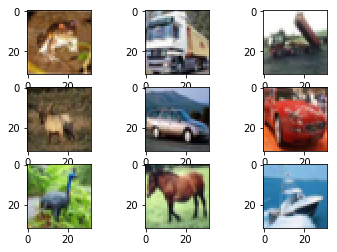

In [8]:
for i in range(9):
    plt.subplot(330+1+i)
    plt.imshow(x_train[i])
plt.show()

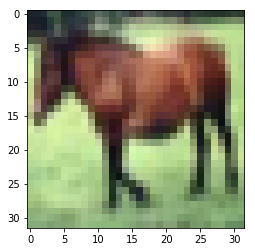

In [9]:
plt.imshow(x_train[7])

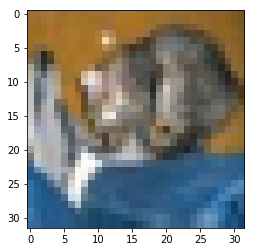

In [10]:
plt.imshow(x_test[0])

In [11]:
m = 60000

In [12]:
num_pix = 32

Spajamo podatke iz skupa za obučavanje i skupa za testiranje jer nam ne odgovara trenutna podela 50 000 : 10 000

In [13]:
img_data = np.vstack((x_train,x_test),)

In [14]:
img_data.shape

(60000, 32, 32, 3)

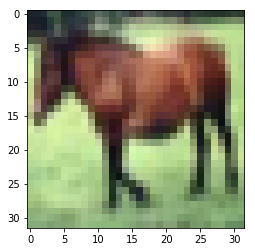

In [15]:
plt.imshow(img_data[7])

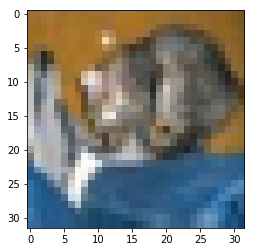

In [16]:
plt.imshow(img_data[50000])

In [17]:
img_gray = np.zeros((m, num_pix, num_pix))

In [18]:
img_gray.shape

(60000, 32, 32)

In [19]:
img_gray_noisy = np.zeros((m, num_pix, num_pix))

Prevodimo originalne fotografije u crno-beli format

In [20]:
img_gray = np.dot(img_data[...,:3], [0.299, 0.587, 0.114])

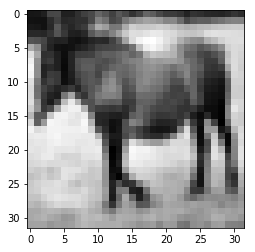

In [21]:
plt.imshow(img_gray[7], cmap = 'gray')

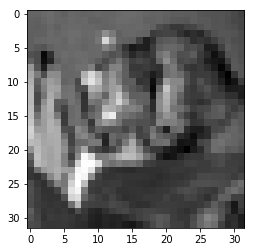

In [22]:
plt.imshow(img_gray[50000], cmap = 'gray')

Funkcija koja dodaje "salt and pepper noise" sa zadatim procentom (crnog i belog) šuma

In [23]:
def sp_noise(image,prob):
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i,j] = 0
            elif rdn > thres:
                output[i,j] = 255
            else:
                output[i,j] = image[i,j]
    return output

Slikama dodajemo 15% šuma (7,5% crno i 7,5% belo)

In [24]:
for k in range(m):
    img_gray_noisy[k] = sp_noise(img_gray[k], 0.075)

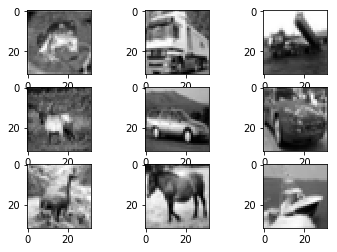

In [25]:
for i in range(9):
    plt.subplot(330+1+i)
    plt.imshow(img_gray[i], cmap = 'gray')
plt.show()

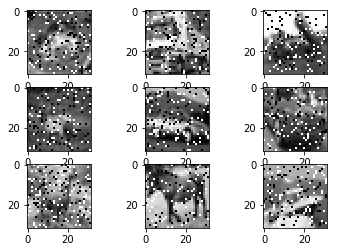

In [26]:
for i in range(9):
    plt.subplot(330+1+i)
    plt.imshow(img_gray_noisy[i], cmap = 'gray')
plt.show()

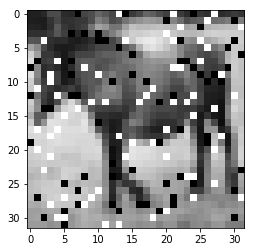

In [27]:
plt.imshow(img_gray_noisy[7], cmap = 'gray')

Funkcija koja detektuje šum tako što ispituje četiri susedna piksela (gore, dole, levo i desno) i računa minimalnu razliku.

In [28]:
def noise_detector1(image, cube_size):
    image_noise_detected = np.zeros(image.shape)
    
    for i in range((cube_size-1)//2, image.shape[0]-(cube_size-1)//2):
        for j in range((cube_size-1)//2, image.shape[1]-(cube_size-1)//2):

            vector1 = [abs(image[i,j] - image[i-1,j]),
                  abs(image[i,j] - image[i,j-1]), abs(image[i,j] - image[i,j+1]),
                  abs(image[i,j] - image[i+1,j])]
            minimum1 = np.min(vector1)
            
            if (minimum1 > 40):
                image_noise_detected[i,j] = 1
            else:
                image_noise_detected[i,j] = 0
                   
    image_noise_detected_red = image_noise_detected[((cube_size-1)//2):(image.shape[0]-(cube_size-1)//2),\
                                                    ((cube_size-1)//2):(image.shape[1]-(cube_size-1)//2)]
    Y_noise_detected = np.transpose(image_noise_detected_red).reshape((image.shape[0]-(cube_size-1))*(image.shape[1]-(cube_size-1)),1)
    return Y_noise_detected

In [29]:
noisy_img = img_gray_noisy[7].astype(int)

In [30]:
detected = noise_detector1(noisy_img,5)

Procenat detektovanog šuma

In [31]:
p = len(detected[detected==1])/len(detected)
p

0.09438775510204081

In [32]:
cube_size = 5

Matrica koja pokazuje na kojim pikselima je detektovan šum

In [33]:
C = np.transpose(detected.reshape(((num_pix-(cube_size-1)),(num_pix - (cube_size-1))))).astype(int)
C

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 

Pogledaćemo kako funkcija radi na primeru osme fotografije iz baze

In [34]:
img = img_gray_noisy[7][2:-2,2:-2].copy()

Sve piksele na kojima je detektovan šum ćemo pretvoriti u crne. Tako možemo da vidimo sve bele šumove koje funkcija nije detektovala.

In [35]:
img[C==1] = 0

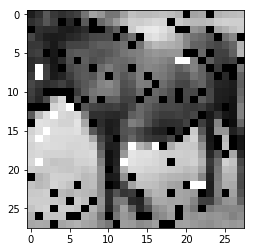

In [36]:
plt.imshow(img, cmap = 'gray')

Funkcija ne detektuje bele šumove u slučaju kada se nalaze na jedan do drugog, horizontalno ili vertikalno.

Sve piksele na kojima je detektovan šum ćemo pretvoriti u bele. Tako možemo da vidimo sve crne šumove koje funkcija nije detektovala.

In [37]:
img[C==1] = 255

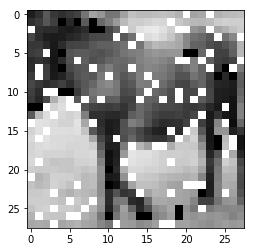

In [38]:
plt.imshow(img, cmap = 'gray')

Funkcija koja detektuje i dva šuma na susednim pikselima.

In [39]:
def noise_detector(image, cube_size):
    image_noise_detected = np.zeros(image.shape)
    
    for i in range((cube_size-1)//2, image.shape[0]-(cube_size-1)//2):
        for j in range((cube_size-1)//2, image.shape[1]-(cube_size-1)//2):

            vector1 = [abs(image[i,j] - image[i-1,j]),
                  abs(image[i,j] - image[i,j-1]), abs(image[i,j] - image[i,j+1]),
                  abs(image[i,j] - image[i+1,j])]
            minimum1 = np.min(vector1)
            vector2 = [abs(image[i,j] - image[i-1,j-1]),
                  abs(image[i,j] - image[i+1,j-1]), abs(image[i,j] - image[i-1,j+1]),
                  abs(image[i,j] - image[i+1,j+1])]
            minimum2 = np.min(vector2)
            if (minimum1 > 40) | (minimum2 > 40):
                image_noise_detected[i,j] = 1
            else:
                image_noise_detected[i,j] = 0
                   
    image_noise_detected_red = image_noise_detected[((cube_size-1)//2):(image.shape[0]-(cube_size-1)//2),\
                                                    ((cube_size-1)//2):(image.shape[1]-(cube_size-1)//2)]
    Y_noise_detected = np.transpose(image_noise_detected_red).reshape((image.shape[0]-(cube_size-1))*(image.shape[1]-(cube_size-1)),1)
    return Y_noise_detected

Pogledaćemo kako funkcija radi na primeru osme fotografije iz baze

In [40]:
noisy_img = img_gray_noisy[7].astype(int)

In [41]:
detected = noise_detector(noisy_img,5)

Procenat detektovanog šuma

In [42]:
p = len(detected[detected==1])/len(detected)
p

0.16709183673469388

In [43]:
cube_size = 5

Matrica koja pokazuje na kojim pikselima je detektovan šum

In [44]:
C = np.transpose(detected.reshape(((num_pix-(cube_size-1)),(num_pix - (cube_size-1))))).astype(int)
C

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 

Sve piksele na kojima je detektovan šum ćemo pretvoriti u crne. Tako možemo da vidimo sve bele šumove koje funkcija nije detektovala.

In [45]:
img = img_gray_noisy[7][2:-2,2:-2].copy()

In [46]:
img[C==1] = 0

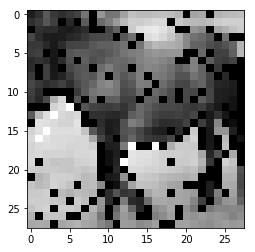

In [47]:
plt.imshow(img, cmap = 'gray')

Sve piksele na kojima je detektovan šum ćemo pretvoriti u bele. Tako možemo da vidimo sve crne šumove koje funkcija nije detektovala.

In [48]:
img[C==1] = 255

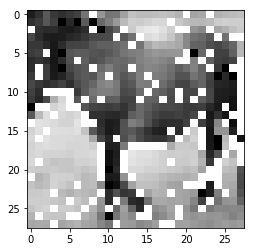

In [49]:
plt.imshow(img, cmap = 'gray')

### Uklanjanje detektovanog šuma

Za ukljanjanje detektovanog šuma koristićemo model linearne regresije. Krećemo se kroz matricu kvadratom dimenzije 5x5.

Za atribute uzimamo:
- 25 pojedinačnih piksela tog kvadrata
- razlike između susednih piksela vertikalno (4*5)
- razlike između susednih piksela horizontalno (5*4)
-  1

Ukupno 66 atributa i 66 parametara

In [50]:
m = 500

In [51]:
x_cell_num = cube_size**2 + 2*cube_size*(cube_size-1)

In [52]:
x_cell_num

65

Greška:

In [53]:
J = 0
J_noisy = 0

Vektor parametara:

In [54]:
theta = np.random.random((x_cell_num + 1,1))

In [55]:
theta.shape

(66, 1)

In [56]:
Y = np.zeros(((num_pix-(cube_size-1))*(num_pix - (cube_size-1)),m), np.float32)

In [57]:
Y_noisy = np.zeros(((num_pix-(cube_size-1))*(num_pix - (cube_size-1)),m),np.float32)

In [58]:
Y_pred = np.zeros(((num_pix-(cube_size-1))*(num_pix - (cube_size-1)),m), np.float32)

Dizajn matrica

In [59]:
X_disp = np.zeros((x_cell_num + 1, (num_pix - (cube_size-1))*(num_pix - (cube_size-1)), m), np.float32)

In [60]:
alpha_initial = 1
alpha = alpha_initial
count = 1

In [61]:
error_train = 1

In [69]:
theta = np.random.random((x_cell_num + 1,1))
#while error_train > 0.001:
#theta = np.random.random((x_cell_num + 1,1))
J = 0
J_noisy = 0
counter = 0

img_pred = np.zeros(((num_pix - (cube_size-1)),(num_pix - (cube_size-1)), m), np.float32)

for w in range(m):
    img_gray_red = img_gray[w, ((cube_size-1)//2):(num_pix-(cube_size-1)//2),\
                    ((cube_size-1)//2):(num_pix-(cube_size-1)//2)].copy().astype('float32')
    img_gray_noisy_red = img_gray_noisy[w, ((cube_size-1)//2):(num_pix-(cube_size-1)//2),\
                    ((cube_size-1)//2):(num_pix-(cube_size-1)//2)].copy().astype('float32')
    #print(img_gray_noisy_red.shape)
    Y[:,w] = img_gray_red.reshape((num_pix-(cube_size-1))*(num_pix - (cube_size-1))).astype('float32')
    #print(img_gray_red.reshape((num_pix-(cube_size-1))*(num_pix - (cube_size-1))).shape)
    Y_noisy[:,w] = img_gray_noisy_red.reshape((num_pix-(cube_size-1))*(num_pix - (cube_size-1))).astype('float32')
    #print(Y_noisy[:,w])

    X_feature = np.zeros((x_cell_num, (num_pix-(cube_size-1))*(num_pix - (cube_size-1))),\
                         np.float32)

    for i in range(((cube_size-1)//2),(num_pix-(cube_size-1)//2)):

        for j in range(((cube_size-1)//2),(num_pix-(cube_size-1)//2)):

            k = (num_pix - (cube_size-1))*(i - ((cube_size-1)//2))+(j-(cube_size-1)//2)
           # if(k < 10):
           #     print(k)

            cell_values = img_gray_noisy[w, (i - (cube_size-1)//2):(i + (cube_size-1)//2+1),\
                                         (j - (cube_size-1)//2):(j + (cube_size-1)//2+1)].copy()

            X_feature[0:cube_size**2,k] = cell_values.reshape(cube_size**2).copy()

            cell_diff_v = (img_gray_noisy[w,(i+1-(cube_size-1)//2):(i+(cube_size-1)//2+1),\
                                         (j-(cube_size)//2):(j+(cube_size-1)//2+1)]-\
            img_gray_noisy[w,(i-(cube_size-1)//2):(i+(cube_size-1)//2),\
                                         (j-(cube_size)//2):(j+(cube_size-1)//2+1)])
            #if k < 3:
            #    print(X_feature[0:cube_size**2,k])

            cell_diff_h = (img_gray_noisy[w,(i-(cube_size-1)//2):(i+(cube_size-1)//2+1),\
                                         (j+1-(cube_size)//2):(j+(cube_size-1)//2+1)]-\
                        img_gray_noisy[w,(i-(cube_size-1)//2):(i+(cube_size-1)//2+1),\
                                         (j-(cube_size)//2):(j+(cube_size-1)//2)])   

            X_feature[cube_size**2:cube_size**2+cube_size*(cube_size-1),k] =\
                            cell_diff_v.reshape(cube_size*(cube_size-1)).copy()
            X_feature[cube_size**2+cube_size*(cube_size-1):, k] =\
                            cell_diff_v.reshape(cube_size*(cube_size-1)).copy()
            #if k < 2:
            #    print(X_feature[cube_size**2+cube_size*(cube_size-1):, k])

    X_feature_mod = np.transpose(np.hstack((np.ones(((num_pix-(cube_size-1))*(num_pix - (cube_size-1)),1)),\
                                            np.transpose(X_feature)))).astype('float32')
    #print(X_feature_mod)
    #print(X_feature_mod.shape)

    for j in range((num_pix-(cube_size-1))*(num_pix - (cube_size-1))):

        if Y_noisy[j,w] != Y[j,w]:
            theta_old = theta
            alpha = alpha_initial/(count+w)
            #print(X_feature_mod[:,j].shape)
            #print(theta.shape)
            #print(np.transpose(np.dot(np.transpose(theta),X_feature_mod[:,j])- np.transpose(Y[j,w])).shape)
            U = alpha*X_feature_mod[:,j]
            U = U.reshape(66,1)
            #print(U.shape)
            V = np.transpose(np.dot(np.transpose(X_feature_mod[:,j]), theta) - np.transpose(Y[j,w]))
            V = V.reshape(1,1)
            #print(V.shape)
            Z = np.dot(U, V)
            #print(Z.shape)
            theta = theta - Z/LA.norm(Z)
            #print(theta.shape)
            #theta = theta - np.dot(alpha*X_feature_mod[:,j],np.transpose(np.dot(np.transpose(theta),X_feature_mod[:,j])
            #  - np.transpose(Y[j,w])))/LA.norm(np.dot((alpha*X_feature_mod[:,j]),
            #    np.transpose(np.dot(np.transpose(theta),X_feature_mod[:,j])- np.transpose(Y[j,w]))))

    if w < np.ceil(0.7*m):

        for j in range((num_pix-(cube_size-1))*(num_pix - (cube_size-1))):

            if Y_noisy[j,w] != Y[j,w]:
                U = np.dot(np.transpose(X_feature_mod[:,j]),theta)
                #print(U)
                V = U - np.transpose(Y[j,w])
                Z = np.dot(V, np.transpose(V))
                J = J + 0.5*Z
                #J = J + 0.5*np.dot(np.dot(np.dot(np.transpose(theta),X_feature_mod[:,j]) - np.transpose(Y[j,w])),\
                #np.transpose(np.dot(np.transpose(theta),X_feature_mod[:,j]) - np.transpose(Y[j,w])))

                J_noisy = J_noisy + 0.5*np.dot(np.transpose(Y_noisy[j,w] - Y[j,w]),(Y_noisy[j,w] - Y[j,w]))

                counter = counter + 1

    X_disp[:,:,w] = X_feature_mod

error_train = J/(255**2)/(m*(num_pix-((cube_size-1)))*(num_pix-((cube_size-1))))
print(error_train)


error_noisy_train = J_noisy/(255**2)/(m*(num_pix-((cube_size-1)))*(num_pix-((cube_size-1))))
print(error_noisy_train)
count = count + m #60 000
print(count)

for w in range(m):
    temp = np.dot(np.transpose(X_disp[:,:,w]), theta)
    #print(temp.shape)
    temp1 = np.transpose(temp)
    #print(temp1[0,:].shape)
    temp2 = np.uint8(temp1.reshape(784))
    Y_pred[:,w] = temp2
    #print(Y_pred[:,w].shape)
    Y_noise_detect = noise_detector(img_gray_noisy[w].astype(int),cube_size)
    #print(len(Y_noise_detect[Y_noise_detect==0])/len(Y_noise_detect))
    #print(Y_noise_detect[4])
    for j in range((num_pix-(cube_size-1))*(num_pix - (cube_size-1))):
        if np.transpose(Y_noise_detect.reshape((num_pix-(cube_size-1)),(num_pix - (cube_size-1)))).reshape(784)[j] == 0:
            Y_pred[j,w] = Y_noisy[j,w].copy()
    #print(len(Y_pred[:,w][Y_pred[:,w] == Y_noisy[:,w]]))
    img_pred[:,:,w] = Y_pred[:,w].reshape(num_pix - (cube_size-1),num_pix - (cube_size-1))  
    #img_pred1[:,:,w] = np.transpose(Y_noisy[:,w].reshape(num_pix - (cube_size-1),num_pix - (cube_size-1)))



1.5330145799551338
0.01595829477046101
1001


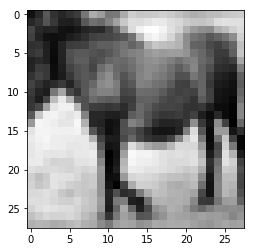

In [63]:
plt.imshow(img_gray[7,2:-2,2:-2], cmap = 'gray')

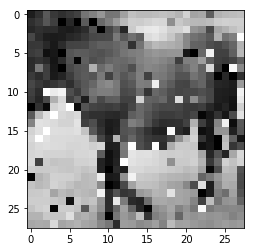

In [64]:
plt.imshow(np.uint8(img_pred[:,:,7]), cmap = 'gray')

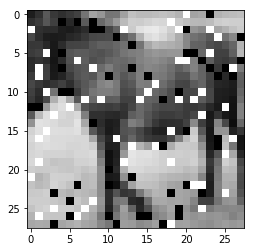

In [65]:
plt.imshow(Y_noisy[:,7].reshape(num_pix - (cube_size-1),num_pix - (cube_size-1)), cmap = 'gray')

In [355]:
J_test = 0
J_noisy_test = 0
counter_test = 0

for w in range(np.int(0.7*m),m):

    for j in range((num_pix-((cube_size-1)))*(num_pix-((cube_size-1)))):
        J_test = J_test + 0.5*(Y_pred[j,w] - Y[j,w])*(Y_pred[j,w] - Y[j,w])
        J_noisy_test = J_noisy_test + 0.5*(Y_noisy[j,w] - Y[j,w])*((Y_noisy[j,w] - Y[j,w]))

        counter_test = counter_test + 1

error_test = J_test/(255^2)/counter_test
error_noisy_test = J_noisy_test/(255^2)/counter_test
 

In [356]:
error_test

55.99335437377166